## Bayesian Statistics, Markov-Chain Monte Carlo, and PyMC

#### Jack Bennetto
#### March 16, 2018

The other day we talked a bit about Bayesian statistics. To review:

Suppose we're considering some hypothesis $H$ and we've collected some data $\mathbf{X}$.
$$ P(H|\mathbf{X}) = \frac{P(\mathbf{X}|H) P(H)}{P(\mathbf{X})} $$

Each term has a name.

* $P(H)$ is the *prior probability*
* $P(\mathbf{X}|H)$ is the *likelihood*.
* $P(\mathbf{X})$ is the *normalizing constant*.
* $P(H|\mathbf{X})$ is the *posterior probability*.


If there are a bunch of hypotheses $H_1, H_2, ... H_n$, we could write this as

$$\begin{align}
P(H_i|\mathbf{X}) & = \frac{P(\mathbf{X}|H_i) P(H_i)}{P(\mathbf{X})}\\
         & = \frac{P(\mathbf{X}|H_i) P(H_i)}{\sum_{j=0}^{n} P(\mathbf{X}|H_j) P(H_j)}
\end{align}
$$

Here we see the normalizing constant is the likelihood times the prior summed over all possible hypothesis. In other words, it's the constant (independent of hypothesis) needed to be multiplied by all the numerators so that they all add up to one.



When you worked that out computationally you saw calculating the normalizing constant was difficult, particularly in cases with an infinite number of possible hypotheses. One approach we took was to use conjugate priors. That's fine for click-through rates but is only available for simple models. The other is to divide the hypothesis space into many slices, but that becomes computationally impossible in high-dimensional space. In particular, that means giving the same attention to areas that are likely in the posterior as those that are almost impossible.

A third choice is random sampling. We call this a *monte-carlo* approach. In particular we sample many points (hypotheses) from the posterior distribution, transitioning from each point to the next, in what is called Markov-Chain Monte Carlo (MCMC). Although 

There are a number of different approaches to this, but a common one, called the [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm, works like this.

First, we start at a given set of values. We then adjust them slightly (in such way that the probabilities are symmetric) and consider a new point. If it has a higher value for the pdf of the posterior, we accept it automatically. If it's lower, we accept it with a probability of the fraction of the ratio with the dpdf at the current point. Otherwise  we reject the new point. We repeat this many, mnay times.

Today most MCMC approaches use more sophisticated algorithms (pymc3 used NUTS (No-U-Turn Sampling)), but the idea is often similar.


First you need to install pymc3. Try using conda, like this:

`conda install -c conda-forge pymc3`

In [1]:
import scipy.stats as scs
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Experimenting with pymc

Let's start with the coin-flip/CTR example we've seem a couple times before. In this we have data on successes and failures and we want to determine the value of some unknown click-through rate. First, let's make some data!

In [18]:
prob_actual = 0.10
data_ctr = scs.bernoulli(prob_actual).rvs(100)
data_ctr

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0])

In [19]:
data_ctr.mean()

0.14999999999999999

The pymc interface uses the `with` statement in python to specify a model with which we'll be operating. The first time we interact with it we'll need to call the constructor and assign it to a variable with `as`; after that we just refer to that variable. Any variables created are added to that model object automatically, and any sampling or optimization is done on that model.

In general, there are a couple different types of variables. First, we can create a variable that represents some prior distribution of a variable. Here we're just starting with a uniform distribution for a prior. Each object created in the model (usually) needs a name so we can identity it later. 

In [6]:
with pm.Model() as model_ctr:
    prob = pm.Uniform('prob', 0, 1)

The other type of variable in the model is a likelihood, specifying the observed data.

In [7]:
with model_ctr:
    observed = pm.Bernoulli('observed', prob, observed=data_ctr)

Now we do some sampling! The result of sampling is often called a *trace*.

In [12]:
pm.sample?

In [13]:
with model_ctr:
    trace = pm.sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prob_interval__]
100%|██████████| 11000/11000 [00:09<00:00, 1144.79it/s]


In [14]:
trace['prob'].shape

(20000,)

The result of `sample` will contain values for all of the variables, distributed (if we have enough) in the same manner as the posterior distribution of those variables. Let's visualize them.

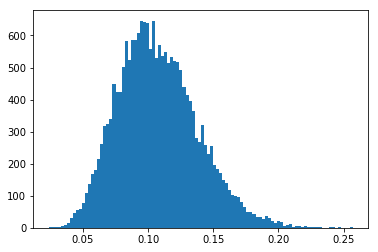

In [15]:
fig, ax = plt.subplots()
ax.hist(trace['prob'], bins=100)
plt.show()

Questions:

Why doesn't it peak at the actual value for the probability (`prob_actual`)?

Why isn't this very smooth?

Is this a beta distribution?

What else can we do with this?

## A (slightly) harder example

Bernoulli distributions aren't all that exciting. Let's sample a few points from a normal distribution and  try to recover the parameters.

In [21]:
mu_actual = 5
sigma_actual = 2
data = scs.norm(mu_actual, sigma_actual).rvs(10)

What do we have?

In [22]:
print("mean = {:.3f} sd = {:.3f}".format(data.mean(), data.std()))

mean = 5.488 sd = 1.774


For now let's assume we know `sigma`, just to make it easier. We'll take a uniform prior for `mu` but assume it's between 0 and 10.

In [23]:
with pm.Model() as model_normal:
    # prior
    mu = pm.Uniform("mu", 0, 10)
    # likelihood
    observed = pm.Normal("observed", mu, 2, observed=data)

We might want to start my calculating the maximum *a posteriori* (MAP) value for the `mu`.

Question: what is MAP?

In [24]:
with model_normal:
    estimate = pm.find_MAP()
estimate

logp = -22.654, ||grad|| = 3.0494: 100%|██████████| 6/6 [00:00<00:00, 362.67it/s]


{'mu': array(5.487897556896676), 'mu_interval__': array(0.1957820049766109)}

In [27]:
with model_normal:
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_interval__]
100%|██████████| 10500/10500 [00:08<00:00, 1231.40it/s]


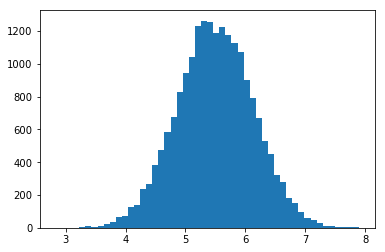

In [30]:
fig, ax = plt.subplots()
ax.hist(trace['mu'], bins=50)
plt.show()

But really we want to estimate both the `mu` and `sigma`. We just need to put both in the model.

In [43]:
with pm.Model() as model_normal2:
    # prior
    mu = pm.Uniform('mu', 0, 100)
    sigma = pm.Uniform('sigma', 0, 10)
    # likelihood
    observed = pm.Normal("observed", mu, sigma, observed=data)

In [41]:
with model_normal2:
    estimate = pm.find_MAP()

logp = -27.865, ||grad|| = 1.0549: 100%|██████████| 18/18 [00:00<00:00, 1108.85it/s] 


Are these the right values?

In [42]:
print("                   mu   sigma")
print("MAP estimate      {:5.3f} {:5.3f}".format(float(estimate['mu']), float(estimate['sigma'])))
print("sample statistics {:5.3f} {:5.3f}".format(data.mean(), data.std()))
print("actual            {:5.3f} {:5.3f}".format(mu_actual, sigma_actual))

                   mu   sigma
MAP estimate      5.488 1.774
sample statistics 5.488 1.774
actual            5.000 2.000


In [45]:
with model_normal2:
    trace = pm.sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, mu_interval__]
100%|██████████| 11000/11000 [00:16<00:00, 685.91it/s]


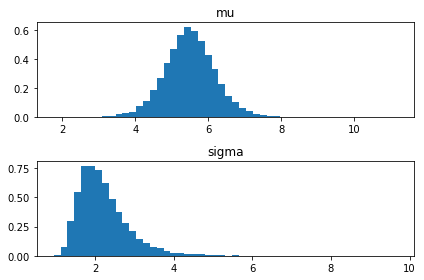

In [46]:
fig, axes = plt.subplots(2)
axes[0].hist(trace['mu'], bins=50, normed=True)
axes[1].hist(trace['sigma'], bins=50, normed=True)
axes[0].set_title("mu")
axes[1].set_title("sigma")
plt.tight_layout()
plt.show()

There's a function to plot this automatically.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113f79f28>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x114186e48>]], dtype=object)

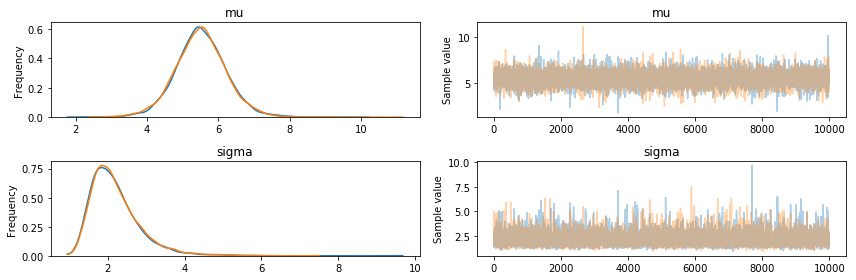

In [47]:
pm.traceplot(trace)

In [48]:
trace.nchains

2

A scatter plot will show us the how they are related.

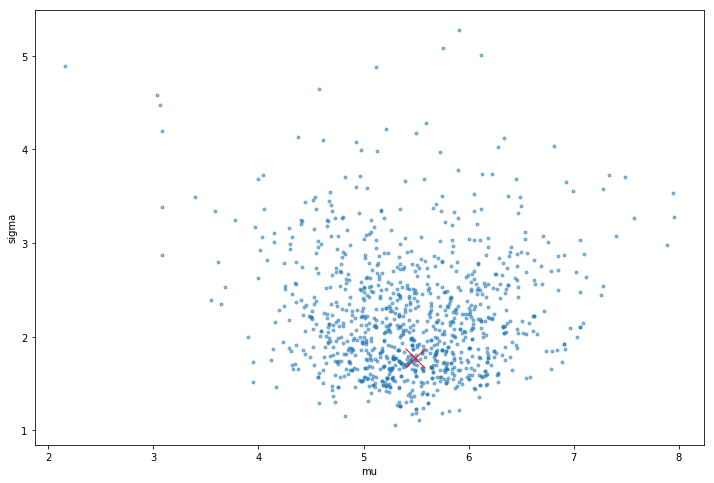

In [53]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(trace['mu'][:1000], trace['sigma'][:1000], '.', alpha=0.5)
#ax.plot(trace['mu'][:1000], trace['sigma'][:1000], '-', alpha=0.5)
ax.set_xlabel('mu')
ax.set_ylabel('sigma')
ax.plot(data.mean(), data.std(), 'rx', ms=20)
plt.show()

Note that these aren't independent. If sigma is small, then mu must be near the optimal value.

## Hierarchical Modelling

Consider the scores of various classes of students on a test. The test is the same, but the students have different teachers, classrooms, materials, etc.

In [77]:
df_scores = pd.read_csv('data/scores.csv')

In [78]:
df_scores.head()

group  score
0      1   0.90
1      1   0.78
2      1   0.68
3      1   0.32
4      1   0.47

In [79]:
df_scores.score.describe()

count    81.000000
mean      0.753827
std       0.169105
min       0.050000
25%       0.660000
50%       0.780000
75%       0.880000
max       1.000000
Name: score, dtype: float64

In [81]:
df_scores.groupby('group').mean()

score
group          
1      0.766316
2      0.736364
3      0.793077
4      0.773333
5      0.708500

We might wonder whether different teachers and such have a significant effect on the scores.

How would we approach the as frequentists?

As Bayesians, we can choose a more nuanced approach.

In [84]:
with pm.Model() as model_scores:
    mu = pm.Uniform('mu', 0, 1)
    sigma = pm.HalfNormal('sigma', 1)
    sd = pm.HalfNormal('sd', 1)
    eta1 = pm.Normal('eta1', mu, sigma)
    eta2 = pm.Normal('eta2', mu, sigma)
    eta3 = pm.Normal('eta3', mu, sigma)
    eta4 = pm.Normal('eta4', mu, sigma)
    eta5 = pm.Normal('eta5', mu, sigma)
    obs1 = pm.Normal('obs1', eta1, sd, observed=df_scores[df_scores.group==1].values)
    obs2 = pm.Normal('obs2', eta2, sd, observed=df_scores[df_scores.group==2].values)
    obs3 = pm.Normal('obs3', eta3, sd, observed=df_scores[df_scores.group==3].values)
    obs4 = pm.Normal('obs4', eta4, sd, observed=df_scores[df_scores.group==4].values)
    obs5 = pm.Normal('obs5', eta5, sd, observed=df_scores[df_scores.group==5].values)
                    

In [85]:
with model_scores:
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eta5, eta4, eta3, eta2, eta1, sd_log__, sigma_log__, mu_interval__]
100%|██████████| 1500/1500 [00:06<00:00, 222.80it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115587128>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x112e43080>]], dtype=object)

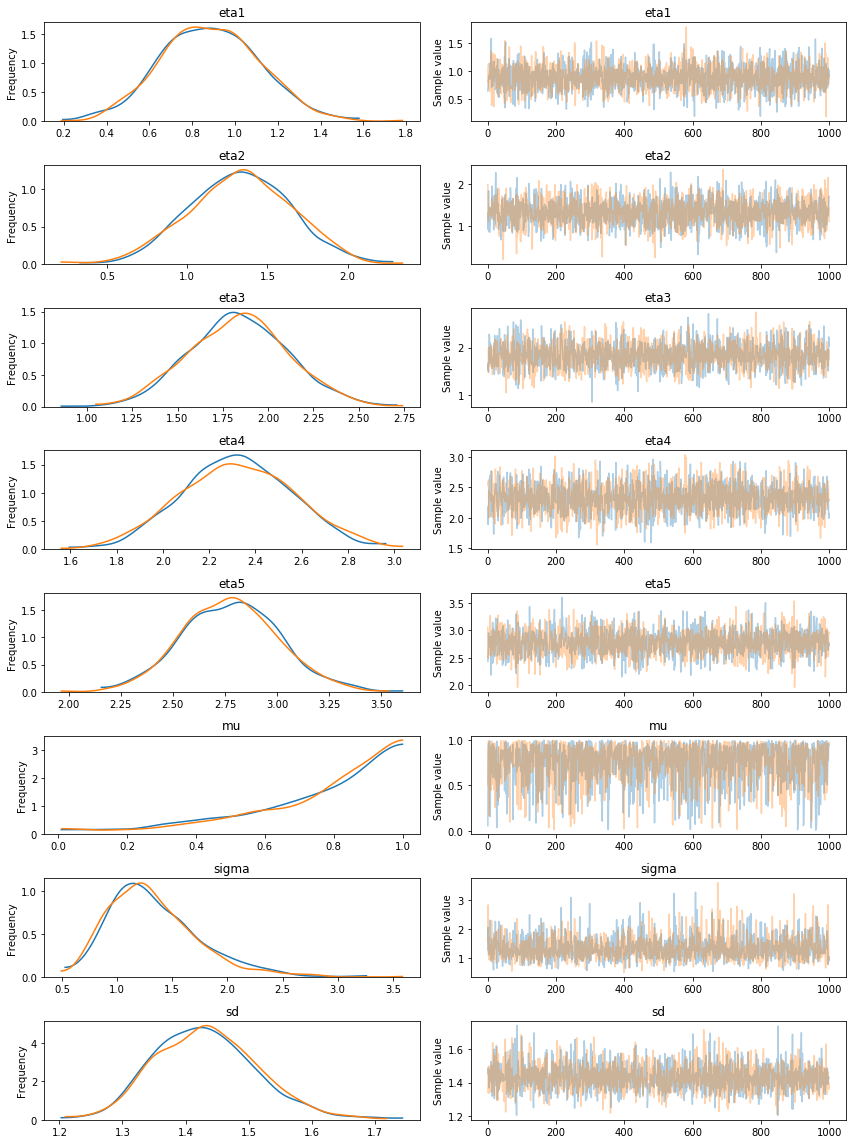

In [86]:
pm.traceplot(trace)